In [15]:
!pip install pandas
!pip install numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Arrival and Service rates

λ = 20               # calls per hour
μ = 5                # calls served per agent per hour
shift_hours = 8      # 8-hour shift

# Simulation settings
np.random.seed(21)

In [16]:
def simulate_queue(s):
    '''    Simulate an M/M/s queue over 'shift_hours'.
    Returns arrays of wait times (hrs) and system sizes at arrivals.
    '''

# generate arrival times until the end of shift
    inter = np.random.exponential(1/λ, int(λ*shift_hours*1.5))
    arrivals = np.cumsum(inter)
    arrivals = arrivals[arrivals < shift_hours]
    N = len(arrivals)
# generate service times for each caller
    services = np.random.exponential(1/μ, N)

    # track each server's next-free time
    next_free = np.zeros(s)
    wait_times = np.zeros(N)
    system_size = np.zeros(N)
# departure times list
    dep_times = []

    for i, t in enumerate(arrivals):
        # find soonest-available agent
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait_times[i] = start - t
        end = start + services[i]
        next_free[j] = end
        dep_times.append(end)
# Count how many callers are still in system at time t
        system_size[i] = np.sum(np.array(dep_times) > t)

    return wait_times, system_size

# quick test for s=1
w1, q1 = simulate_queue(s=1)
print(f"s=1: avg wait {w1.mean()*60:.1f} min, avg queue len {q1.mean():.2f}")

s=1: avg wait 908.5 min, avg queue len 74.34


In [17]:
#3. Compare to M/M/1 Analytic Formula a

# traffic intensity ρ for s=1
ρ1 = λ / μ
L_analytic = ρ1 / (1- ρ1)
W_analytic = L_analytic / λ

print("M/M/1 analytic vs. simulation:")
print(f"  Analytic system size L = {L_analytic:.2f}")
print(f"  Simulated avg system size = {q1.mean():.2f}")
print(f"  Analytic time in system W = {W_analytic*60:.1f} min")
print(f"  Simulated avg wait+service = {w1.mean()*60 + (1/μ)*60:.1f} min")

M/M/1 analytic vs. simulation:
  Analytic system size L = -1.33
  Simulated avg system size = 74.34
  Analytic time in system W = -4.0 min
  Simulated avg wait+service = 920.5 min


In [18]:
#4. Test Staffing Levels(s=1...5)
threshold=5 #minutes
results=[]

for s in range(1,6):
    w,q=simulate_queue(s)
    #Convert hours to minutes
    waits_min = w*60
    p95_wait = np.percentile(waits_min, 95)
    results.append((s,waits_min.mean(),p95_wait,q.mean()))

#tabulate
import pandas as pd
df=pd.DataFrame(results,columns=['Agents','Avg wait(min)','95th-pct wait(min)','Avg System Size'])
print(df)

#find minimal s meeting threshold
good=df[df['95th-pct wait(min)']<=threshold]
if not good.empty:
    best_s=int(good.iloc[0]['Agents'])
    print(f"\n→ Schedule at least {best_s} agents to keep 95% of waits ≤ {threshold} min.")

else:
    print("\nEven 5 agents can't meet the 5 min 95% wait target.")


   Agents  Avg wait(min)  95th-pct wait(min)  Avg System Size
0       1     581.970986         1087.740484        54.483221
1       2     237.411975          436.601258        40.892405
2       3     109.263307          210.025871        29.831325
3       4      20.807699           46.457200        11.341040
4       5       1.679563            9.245414         4.647482

Even 5 agents can't meet the 5 min 95% wait target.


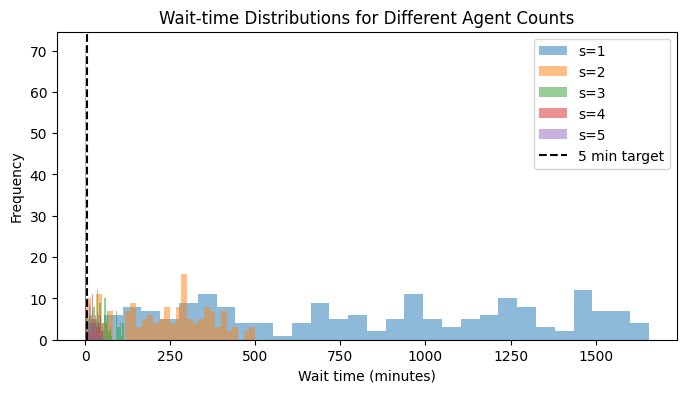

In [19]:
#Visualize Wait-Time Distributions

plt.figure(figsize=(8,4))
for s in [1,2,3,4,5]:
    w, _ = simulate_queue(s)
    plt.hist(w*60,bins=30,alpha=0.5,label=f's={s}')

plt.axvline(threshold, color='k',linestyle='--',label='5 min target')
plt.xlabel('Wait time (minutes)')
plt.ylabel('Frequency')
plt.title('Wait-time Distributions for Different Agent Counts')
plt.legend()
plt.show()

In [20]:
#6. Time-Varying λ

def simulate_queue_timevarying(s):
    # define piecewise arrival rates per hour
    periods=[(0,2,30),(2,6,20),(6,8,40)]#(start,end,λ)
    arrivals=[]
    for start,end,lam in periods:
        duration=end-start
        inter=np.random.exponential(1/lam,int(lam*duration*1.5))
        ts=np.cumsum(inter)+start
        arrivals.extend(ts[ts<end])

    arrivals=np.array(arrivals)
    arrivals.sort()
    
    N=len(arrivals)
    services=np.random.exponential(1/μ,N)
    next_free=np.zeros(s)
    wait_times=np.zeros(N)
    
    for i,t in enumerate(arrivals):
        j=np.argmin(next_free)
        start=max(t,next_free[j])
        wait_times[i]=start-t
        next_free[j]=start+services[i]

    return wait_times

w_tv=simulate_queue_timevarying(s=3)
print((f"Time-varying λ, s=3 → avg wait = {w_tv.mean()*60:.1f} min"))

    # (f"Time-varying λ, s=3 → avg wait = {w_tv.mean()*60:.1f} min")

Time-varying λ, s=3 → avg wait = 169.1 min


In [21]:
# 7. Abandonment
def simulate_with_abandon(s, patience=s/60):
    arrivals = np.cumsum(np.random.exponential(1/λ, int(λ*shift_hours*1.5)))
    arrivals = arrivals[arrivals < shift_hours]
    services = np.random.exponential(1/μ, len(arrivals))
    next_free = np.zeros(s)
    waits = []
    abondons = 0

    for i, t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait = start - t
        if wait > patience:
            abondons += 1

        else:
            waits.append(wait)
            next_free[j] = start + services[i]

    return np.array(waits), abondons/len(arrivals)
    
w, ab_rate = simulate_with_abandon(s=4)
print(f"Abondon rate (s=4): {ab_rate:.2%}, avg wait on served calls: {w.mean()*60:.1f} min")
# Shows the trade-off: fewer agents → more abandonments → lost revenue and satisfaction.


Abondon rate (s=4): 27.81%, avg wait on served calls: 1.3 min


In [22]:
#8. Agent Break Scheduling
#s:no of agents
def simulate_with_breaks(s,break_start=3,break_length=0.25):
    arrivals=np.cumsum(np.random.exponential(1/λ,int(λ*shift_hours*1.5)))
    arrivals=arrivals[arrivals < shift_hours]
    services=np.random.exponential(1/μ,len(arrivals))
    next_free=np.zeros(s)
    waits=[]

    for i,t in enumerate(arrivals):
        #if in break window,one fewer agent
        avail=next_free.copy()
        if break_start<t<break_start+break_length:
            avail=np.delete(avail,0) #remove one agent
        j=np.argmin(avail)
        start=max(t,avail[j])
        waits.append(start-t)
        #Update that agent's free time in original array
        idx=j+(1 if break_start< t < break_start+break_length else 0)
        next_free[idx]=start+services[i]

    return np.array(waits)

w_b = simulate_with_breaks(s=3)
print(f"With breaks, s=3→ avg wait = {w_b.mean()*60:.1f} min")

#See the "break-time spike" in waiting.

With breaks, s=3→ avg wait = 43.1 min


In [23]:
#9. Cost Optimization
c_agent=20 # $20/hr per agent
c_wait=0.50 # $0.50 per minute waited

costs=[]

for s in range(1,6):
    w, _ = simulate_with_abandon(s) #or choose another sim fn
    total_wait_cost=w.sum()*60*c_wait
    staff_cost=s*c_agent*shift_hours
    costs.append((s,staff_cost+total_wait_cost))

opt=min(costs, key=lambda x:x[1])
print("Agent count, total cost:")

for s,c in costs:print(f" s={s}: ${c:,.0f}")
print(f" → Optimal s by cost = {opt[0]}")

Agent count, total cost:
 s=1: $214
 s=2: $383
 s=3: $559
 s=4: $729
 s=5: $858
 → Optimal s by cost = 1


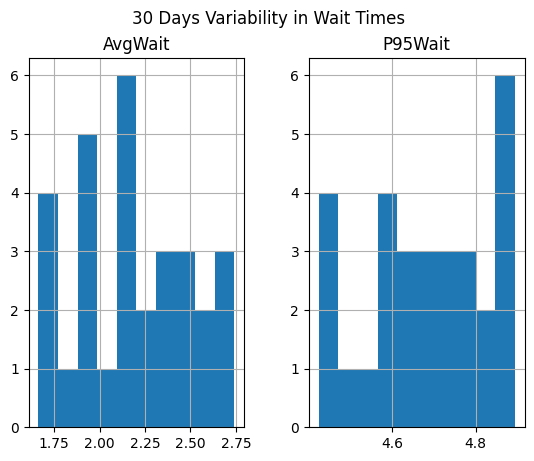

In [24]:
#10. 30 day simulation
days=30
daily=[]

for _ in range(days):
    w, _ = simulate_with_abandon(opt[0])
    daily.append((w.mean()*60, np.percentile(w*60,95)))

df_days=pd.DataFrame(daily,columns=['AvgWait','P95Wait'])
df_days.describe()
df_days.hist(bins=10)
plt.suptitle('30 Days Variability in Wait Times')
plt.show()

In [25]:
df_days

,AvgWait,P95Wait
0,1.898688,4.630672
1,2.474782,4.839695
2,2.163433,4.631507
3,2.574693,4.459721
4,2.221402,4.752816
5,2.118665,4.621047
6,1.768033,4.602137
7,2.182368,4.446994
8,2.099057,4.818754
9,2.449559,4.699635


In [26]:
df_days.describe()

,AvgWait,P95Wait
count,30.000000,30.000000
mean,2.189530,4.685490
std,0.310768,0.144403
min,1.663861,4.424523
25%,1.936995,4.592379
50%,2.180459,4.694121
75%,2.436643,4.813402
max,2.741662,4.893697
